# RBM on BinaryAlpjaDigitsDataset

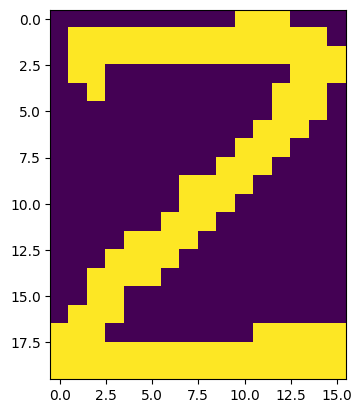

In [1]:
from principal_RBM_alpha import *

plt.imshow(BinaryAlphaDigitsDataset(restrict_labels=['z']).data[1])

In [2]:
rbm = init_RBM(320, 100)
train_RBM(rbm, epochs=1001, ds=BinaryAlphaDigitsDataset(restrict_labels=['z']))

Epoch 1 - Reconstruction error: 0.1842227244348992
Epoch 11 - Reconstruction error: 0.08699372717186174
Epoch 21 - Reconstruction error: 0.0581410847311389
Epoch 31 - Reconstruction error: 0.04080079325266897
Epoch 41 - Reconstruction error: 0.028094009021342414
Epoch 51 - Reconstruction error: 0.01840370714087114
Epoch 61 - Reconstruction error: 0.012671184582641873
Epoch 71 - Reconstruction error: 0.009270747074892238
Epoch 81 - Reconstruction error: 0.007015355955468236
Epoch 91 - Reconstruction error: 0.00539085185602749
Epoch 101 - Reconstruction error: 0.004027621996626525
Epoch 111 - Reconstruction error: 0.0032208446400150944
Epoch 121 - Reconstruction error: 0.0025017170470798
Epoch 131 - Reconstruction error: 0.0021042281593055046
Epoch 141 - Reconstruction error: 0.0017556230478458419
Epoch 151 - Reconstruction error: 0.0013831344165036845
Epoch 161 - Reconstruction error: 0.0012758155050475132
Epoch 171 - Reconstruction error: 0.0010893685625349618
Epoch 181 - Reconstructio

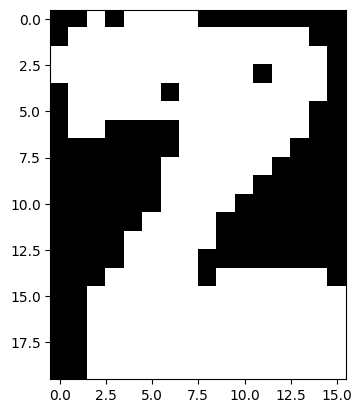

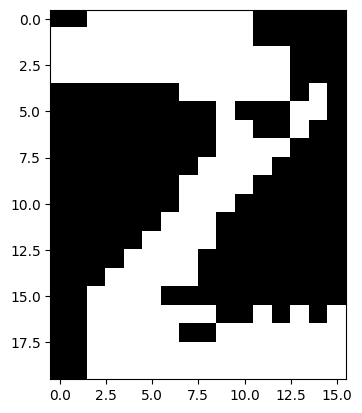

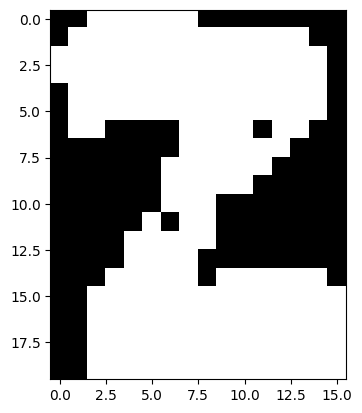

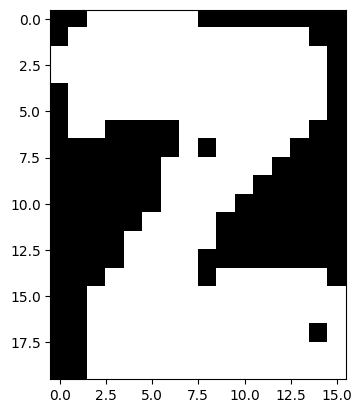

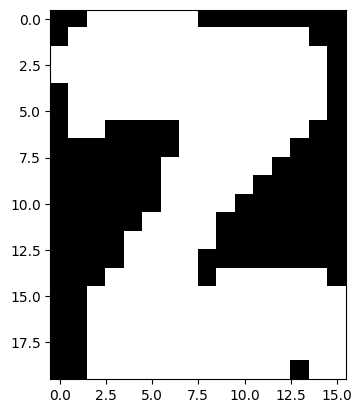

In [3]:
generer_image_RBM(rbm, num_iterations=1000, num_images=5)

# brouillon dnn

In [6]:
def init_DBN(sizes):
    num_layers = len(sizes)
    dbn = []
    for i in range(num_layers-1):
        rbm = init_RBM(sizes[i], sizes[i+1])
        dbn.append(rbm)
    return dbn

def dataset_mapper(dataset, function):
    data = dataset.data
    data = data.reshape((data.shape[0], -1))
    dataset.data = function(data)
    print('mapped to shape', dataset.data.shape)
    return dataset

def train_DBN(dbn, num_iterations, learning_rate, batch_size, ds):
    num_layers = len(dbn)
    for i in range(num_layers):
        print(f"Training RBM {i+1}")
        train_RBM(dbn[i], epochs=num_iterations, learning_rate=learning_rate, batch_size=batch_size, ds=ds)
        ds = dataset_mapper(ds, lambda x: entree_sortie_RBM(dbn[i], x))
    return dbn

In [44]:
dbn = init_DBN([320, 200, 320])
dbn = train_DBN(dbn, 1000, 1e-1, 64, ds=BinaryAlphaDigitsDataset(restrict_labels=['z']))

Training RBM 1
Epoch 1 - Reconstruction error: 0.25083652375973353
Epoch 11 - Reconstruction error: 0.1461469585370494
Epoch 21 - Reconstruction error: 0.14140907811601378
Epoch 31 - Reconstruction error: 0.12415981581871059
Epoch 41 - Reconstruction error: 0.10957931946753552
Epoch 51 - Reconstruction error: 0.0981705163166927
Epoch 61 - Reconstruction error: 0.08967953199175943
Epoch 71 - Reconstruction error: 0.08430212393984378
Epoch 81 - Reconstruction error: 0.08025889572753162
Epoch 91 - Reconstruction error: 0.07649401955355122
Epoch 101 - Reconstruction error: 0.07389680328560125
Epoch 111 - Reconstruction error: 0.06996536086510646
Epoch 121 - Reconstruction error: 0.06682901910744954
Epoch 131 - Reconstruction error: 0.06336105011646416
Epoch 141 - Reconstruction error: 0.05976615858925466
Epoch 151 - Reconstruction error: 0.05652816159929447
Epoch 161 - Reconstruction error: 0.05297697084342486
Epoch 171 - Reconstruction error: 0.051063346837406896
Epoch 181 - Reconstructio

In [45]:
def generer_image_DNN(dbn, num_iterations, num_images):
    for i in range(num_images):
        v = np.random.binomial(1, 0.5, size=dbn[0]['a'].shape[1])
        for rbm in dbn:
            print('o')
            for j in range(num_iterations):
                h = entree_sortie_RBM(rbm, v)
                h = np.random.binomial(n=1, p=h)
                v = sortie_entree_RBM(rbm, h)
                v = np.random.binomial(n=1, p=v)
        plt.imshow(v.reshape(16, 20), cmap='gray')
        plt.show()

o
o


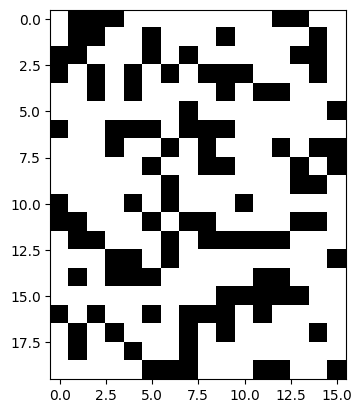

In [46]:
num_iterations, num_images = 1000, 1
for i in range(num_images):
    v = np.random.binomial(1, 0.5, size=dbn[0]['a'].shape[1])
    for rbm in dbn:
        print('o')
        for j in range(num_iterations):
            h = entree_sortie_RBM(rbm, v)
            h = np.random.binomial(n=1, p=h)
            v = sortie_entree_RBM(rbm, h)
            v = np.random.binomial(n=1, p=v)
        v = entree_sortie_RBM(rbm, v)
        v = np.random.binomial(n=1, p=v)
    plt.imshow(v.reshape(20, 16), cmap='gray')
    plt.show()